In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 23.56 MiB/s, done.


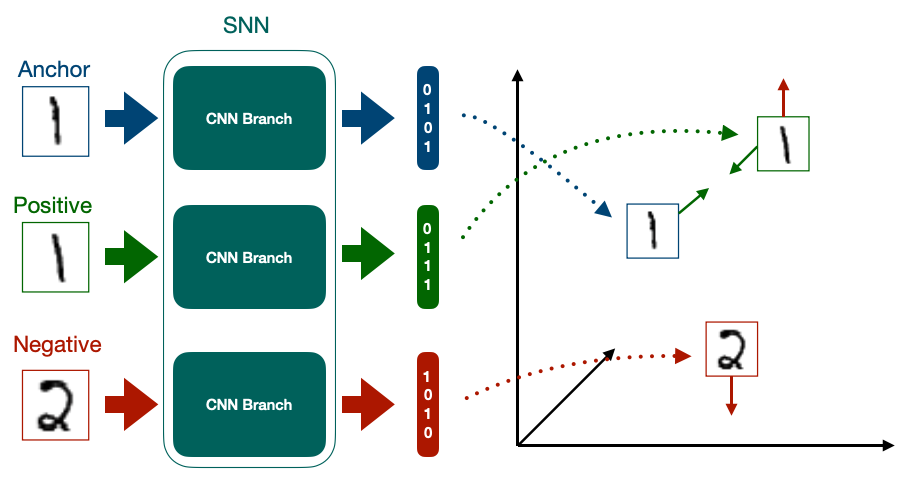

# Imports

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[4]

A_img = io.imread(DATA_DIR + '/' + row['Anchor'])
P_img = io.imread(DATA_DIR + '/' + row['Positive'])
N_img = io.imread(DATA_DIR + '/' + row['Negative'])

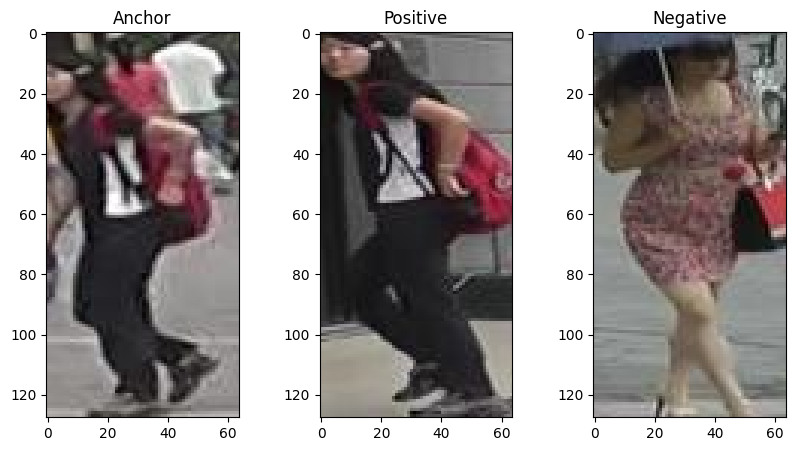

In [ ]:
f,(ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [ ]:
train_df , valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Create APN Dataset

In [ ]:
class APN_Dataset(Dataset):
  def __init__(self, df, data_dir):
    self.df = df
    self.data_dir = data_dir

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    A_img = io.imread(DATA_DIR + '/' + row['Anchor'])
    P_img = io.imread(DATA_DIR + '/' + row['Positive'])
    N_img = io.imread(DATA_DIR + '/' + row['Negative'])

    A_img = torch.from_numpy(A_img).permute(2,0,1)/255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1)/255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1)/255.0
    return A_img, P_img, N_img



In [ ]:
trainset = APN_Dataset(train_df, DATA_DIR)
validset = APN_Dataset(valid_df, DATA_DIR)

print(f"Length of trainset : {len(trainset)}")
print(f"Length of validset : {len(validset)}")

Length of trainset : 3200
Length of validset : 800


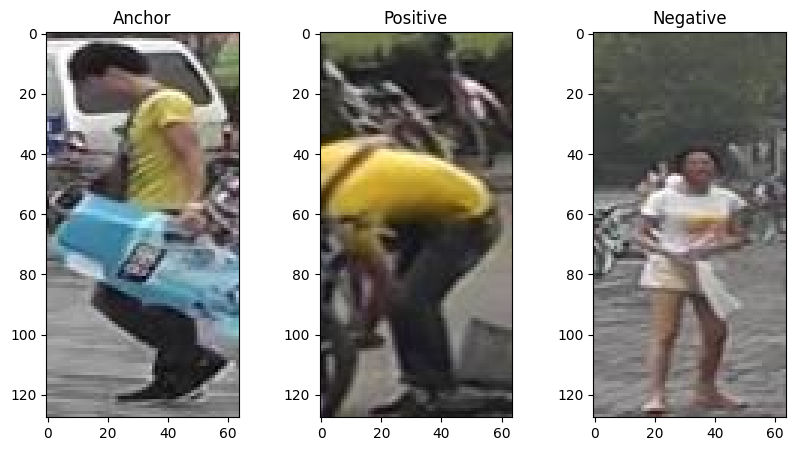

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A, P, N in trainloader:
  # print(f"Anchor batch shape : {A.shape}")
  # print(f"Positive batch shape : {P.shape}")
  # print(f"Negative batch shape : {N.shape}")
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [ ]:
# class APN_Model(nn.Module):
#   def __init__(self, model_name,emb_size = 512, pretrained = True):
#     super().__init__()
#     self.efficientnet = timm.create_model(model_name, pretrained = pretrained)
#     self.efficientnet.classifer = nn.Linear(in_features=self.efficientnet.classifer.in_features, out_features = emb_size)
#   def forward(self, images):
#     embeddings = self.efficientnet(images)
#     return embeddings

class APN_Model(nn.Module):
  def __init__(self, emb_size = 512):
    super().__init__()
    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

  # def get_embedding(self, images):
  #   embeddings = self.efficientnet(images)
  #   return embeddings



In [ ]:
model = APN_Model(512)
model.to(DEVICE);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Create Train and Eval function

In [ ]:
def train_fn(model, data_loader, optimizer, criterion):
  model.train()
  total_loss = 0

  for A, P, N in tqdm(data_loader):
    A = A.to(DEVICE)
    P = P.to(DEVICE)
    N = N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return total_loss/len(data_loader)

In [ ]:
def eval_fn(model, data_loader,  criterion):
  model.train()
  total_loss = 0.0

  with torch.no_grad():
      for A, P, N in tqdm(data_loader):
        A = A.to(DEVICE)
        P = P.to(DEVICE)
        N = N.to(DEVICE)
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)
        loss = criterion(A_embs, P_embs, N_embs)
        total_loss += loss.item()
      return total_loss/len(data_loader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.inf
for epoch in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if train_loss < best_valid_loss:
    best_valid_loss = train_loss
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")

  print(f"Epoch : {epoch+1}")
  print(f"Train Loss : {train_loss}")
  print(f"Valid Loss : {valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 1
Train Loss : 0.6128824622929097
Valid Loss : 0.5627861100435257


100%|██████████| 25/25 [00:03<00:00,  7.67it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 2
Train Loss : 0.35596585273742676
Valid Loss : 0.4029469579458237


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 3
Train Loss : 0.16049819186329842
Valid Loss : 0.3394301664829254


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 4
Train Loss : 0.11809831455349923
Valid Loss : 0.21806836664676665


100%|██████████| 25/25 [00:04<00:00,  6.14it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 5
Train Loss : 0.08491616956889629
Valid Loss : 0.21890877008438112


100%|██████████| 25/25 [00:04<00:00,  6.00it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 6
Train Loss : 0.09074828878045083
Valid Loss : 0.2101890254020691


100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 7
Train Loss : 0.08992975756525994
Valid Loss : 0.16427284717559815


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 8
Train Loss : 0.0581702484190464
Valid Loss : 0.16223496019840242


100%|██████████| 25/25 [00:03<00:00,  7.51it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 9
Train Loss : 0.054022416025400165
Valid Loss : 0.18032069027423858


100%|██████████| 25/25 [00:03<00:00,  7.51it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 10
Train Loss : 0.031008304655551912
Valid Loss : 0.14653507590293885


100%|██████████| 25/25 [00:03<00:00,  7.58it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 11
Train Loss : 0.030528360456228257
Valid Loss : 0.17214367657899857


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 12
Train Loss : 0.029319261088967322
Valid Loss : 0.138327077627182


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 13
Train Loss : 0.029195638746023177
Valid Loss : 0.1856147053837776


100%|██████████| 25/25 [00:04<00:00,  5.94it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 14
Train Loss : 0.026978792548179628
Valid Loss : 0.16220207154750824


100%|██████████| 25/25 [00:04<00:00,  6.03it/s]


SAVED_WEIGHTS_SUCCESS
Epoch : 15
Train Loss : 0.03623508423566818
Valid Loss : 0.18859579801559448


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names = np.array(anc_img_names)
    encodings = []
    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names):
            A = io.imread(DATA_DIR + '/' + i)
            A = torch.from_numpy(A).permute(2, 0, 1) / 255.0

            A = A.to(DEVICE)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)

        # Naming the columns
        df_enc = pd.concat([pd.Series(anc_img_names, name='Anchor'), encodings], axis=1)

    return df_enc


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, train_df['Anchor'])

100%|██████████| 3200/3200 [00:36<00:00, 86.64it/s]


In [ ]:
df_enc.to_csv('database.csv', index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,0326_c3s3_081044_04.jpg,-0.108887,1.064610,-1.439526,-0.416834,-1.481333,-0.081467,-0.427541,0.750627,-0.041669,...,1.242075,0.144063,-0.131891,0.556672,-0.201742,-0.662680,-1.231618,-0.856707,-0.658590,-0.440797
1,0724_c3s2_079903_02.jpg,0.163084,-0.233385,-0.407734,-0.598371,-0.507098,0.163925,0.364497,0.239670,0.115202,...,0.715903,0.503304,0.258310,0.346176,0.368748,-0.422010,0.214081,-0.872474,-0.867459,0.297621
2,0809_c4s4_047835_02.jpg,-0.188877,-0.204859,-0.196704,-0.543989,-0.456533,0.037329,0.257623,0.236473,-0.355167,...,-0.130322,0.503219,0.310276,-0.212939,0.499414,-0.274859,-0.866581,-0.245659,-0.335792,-0.058319
3,0603_c6s2_011218_01.jpg,0.343679,1.066445,-1.352369,-0.259263,-1.242348,0.036971,-0.233501,0.909136,-0.427928,...,0.654919,-0.146332,0.369451,0.037577,-0.003616,-0.921560,-0.943491,-0.700692,-0.289422,-0.200026
4,0594_c3s2_019937_04.jpg,0.085047,0.342508,0.104431,-0.530747,-0.257844,0.441143,0.509650,0.459338,-0.465333,...,-0.777407,-0.574163,-0.315756,-0.380164,-0.172799,-0.734797,-1.267154,-0.275505,0.013192,0.064215


In [ ]:
print(df_enc.columns)


Index(['Anchor',        0,        1,        2,        3,        4,        5,
              6,        7,        8,
       ...
            502,      503,      504,      505,      506,      507,      508,
            509,      510,      511],
      dtype='object', length=513)


# Inference

In [ ]:
def euclidean_distance(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
  return dist

In [ ]:
Trueidx = 5  # Index of the image in the DataFrame
img_name = df_enc['Anchor'].iloc[Trueidx]
img_path = os.path.join(DATA_DIR, img_name)  # Ensure the correct path with 'train' subdirectory

# Check if the file exists
if os.path.exists(img_path):
    img = io.imread(img_path)
    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

    model.eval()
    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.squeeze().cpu().detach().numpy()
else:
    print(f"File not found: {img_path}")


img_path

'/content/Person-Re-Id-Dataset/train/0272_c6s1_057476_01.jpg'

In [ ]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_distance(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)
closest_idx

array([   5,  778,  349, ..., 1086, 3000, 2090])

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


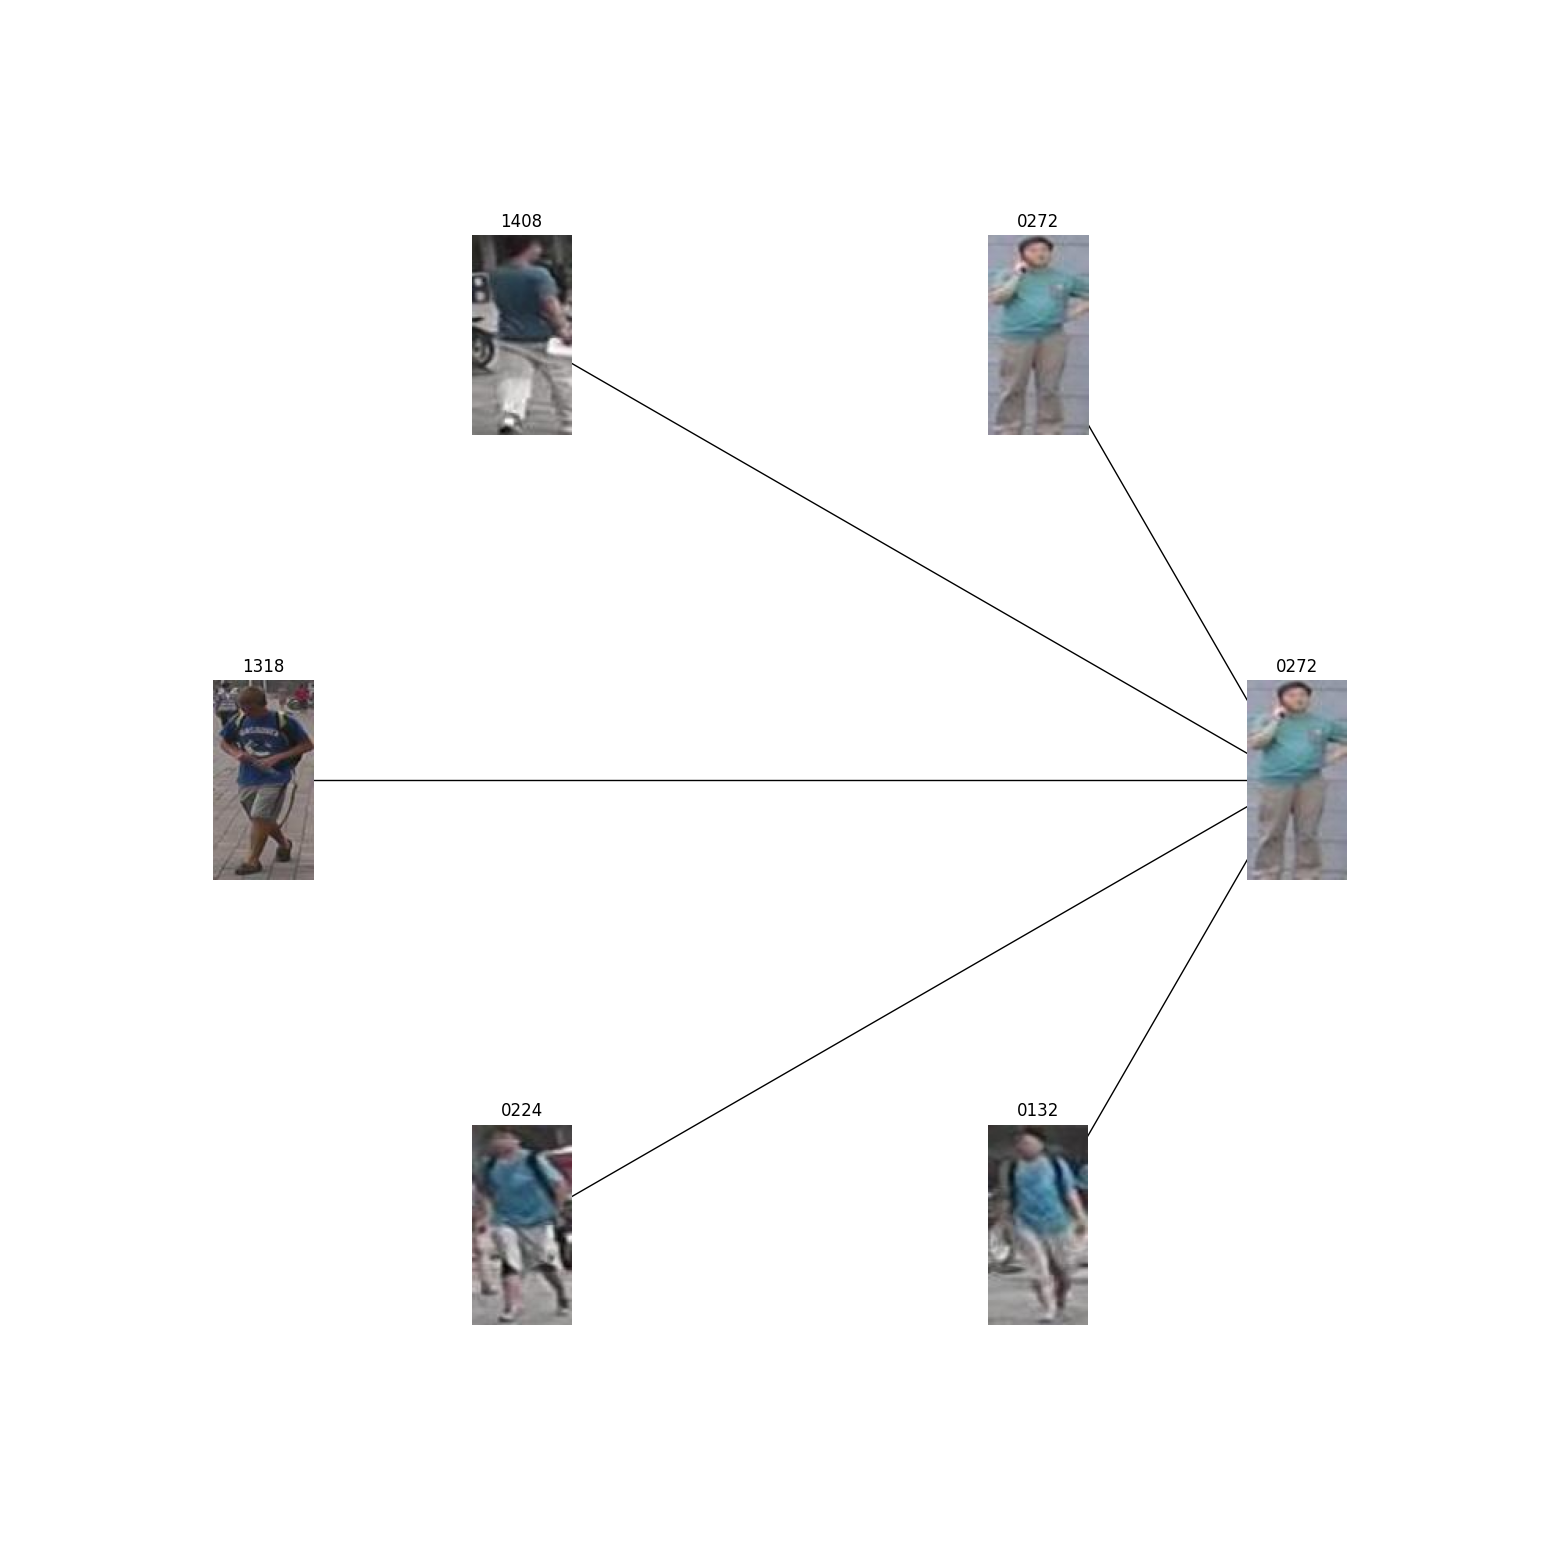

In [ ]:
from utils import plot_closest_imgs

# Correctly pass DATA_DIR without adding 'train' again
plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest=5)
